## Нейронные сети

Построим нейросетевой классификатор для набора данных [MNIST](https://www.kaggle.com/c/digit-recognizer).

In [ ]:
import keras
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
import matplotlib.pyplot as plt
import itertools
# import seaborn as sns

# Функция для рисования confusion_matrix 
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Факт')
    plt.xlabel('Прогноз\naccuracy={:0.4f};   misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Обучение классификатора и вывод loss-function, accuracy
def fit_and_plot(model, X_train, y_train, X_test, y_test, epochs=30, batch_size=32, fit_verbose=0, plot=True):
    train_history = model.fit(X_train, y_train,
                              validation_data=(X_test, y_test),
                              shuffle=True,
                              epochs=epochs,
                              batch_size=batch_size,
                              verbose=fit_verbose)
    
    if plot:
        history = pd.DataFrame(data=train_history.history)
        history[['loss', 'val_loss']].plot()
        history[['acc', 'val_acc']].plot()

# Вывод classification_report и confusion_matrix
def report(model, X_test, y_test):

    y_pred = model.predict(X_test.reshape(-1, m)) 
    y_pred=np.argmax(y_pred, axis=1)              

    print(classification_report(y_test, y_pred, target_names=target_names))

    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm=cm, 
                          normalize=False,
                          target_names=target_names)

In [ ]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
n = X_train.shape[0]
m = X_train.shape[1]*X_train.shape[2]
nclasses = 10
target_names=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

In [ ]:
# One-hot encoding
from keras.utils import np_utils

y_train_enc = keras.utils.np_utils.to_categorical(y_train, nclasses)
y_test_enc = keras.utils.np_utils.to_categorical(y_test, nclasses)

In [ ]:
# Масштабируем признаки до значений [0, 1] 
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

### Базовое решение

В качестве базового решения примем следующую модель, содержащую только входной и выходной слои.

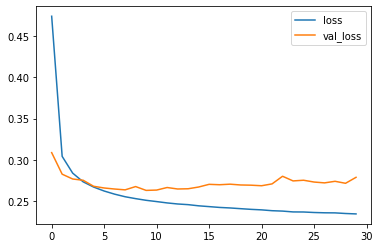

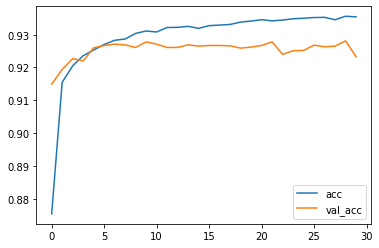

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Input

model = Sequential()
model.add(Input(shape=(m, ),
                name="Input",
                ))

model.add(Dense(units=nclasses,
                activation='softmax',
                name="Output",
                ))

model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['acc'],
              )

fit_and_plot(model, X_train.reshape(-1, m), y_train_enc, X_test.reshape(-1, m), y_test_enc, epochs=30)

По графику loss-function можно увидеть, что с увеличением количества эпох модель начинает переобучаться, а accuracy на тесте колеблется около одного значения ~0.925.

Заново обучим модель на 8-ми эпохах, избежав переобучения и сократив время вычислений.

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.92      1032
           3       0.91      0.92      0.91      1010
           4       0.94      0.93      0.94       982
           5       0.92      0.86      0.89       892
           6       0.95      0.95      0.95       958
           7       0.92      0.94      0.93      1028
           8       0.87      0.90      0.89       974
           9       0.92      0.91      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



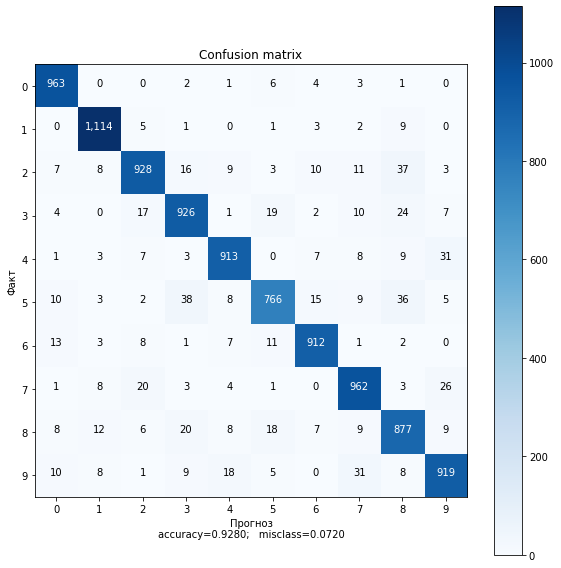

In [ ]:
fit_and_plot(model, X_train.reshape(-1, m), y_train_enc, X_test.reshape(-1, m), y_test_enc, epochs=8, plot=False)
report(model, X_test, y_test)

Итак, в данной модели получили accuracy = 0.9280. 

Можно заметить, что наименьший recall, равный 0.86, имеет "5", которая зачастую ошибочно определялась моделью как "3" или "8".

Улучшим модель!

### Расширенное решение 1

В базовую модель добавим скрытый слой.

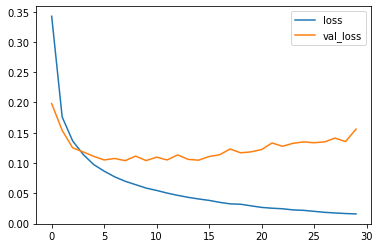

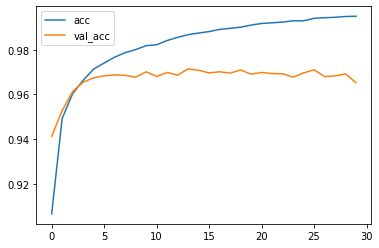

In [ ]:
model = Sequential()
model.add(Input(shape=(m, ),
                name="Input",
                ))
model.add(Dense(units=36,
                name="Hidden",
                activation="relu",
                ))
model.add(Dense(units=nclasses,
                activation='softmax',
                name="Output",
                ))

model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['acc'],
              )

fit_and_plot(model, X_train.reshape(-1, m), y_train_enc, X_test.reshape(-1, m), y_test_enc, epochs=30)

В целом, метрики качества улучшились, по сравнению с базовой моделью, но модель стала сильнее переобучаться. Так же заново обучим модель на 8-ми эпохах, избежав этого.

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.95      0.97      0.96      1010
           4       0.96      0.97      0.97       982
           5       0.95      0.96      0.95       892
           6       0.98      0.97      0.97       958
           7       0.97      0.97      0.97      1028
           8       0.97      0.94      0.96       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



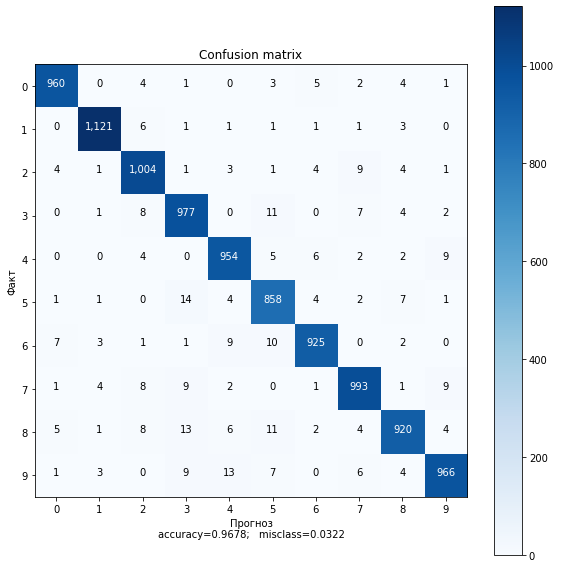

In [ ]:
fit_and_plot(model, X_train.reshape(-1, m), y_train_enc, X_test.reshape(-1, m), y_test_enc, epochs=8, plot=False)
report(model, X_test, y_test)

Данная модель распознает цифры намного лучше и accuracy составляет 0.9678.

### Расширенное решение 2

Построим сверточную нейронную сеть следующей структуры.

Epoch 1/30
263/263 [==============================] - 27s 102ms/step - loss: 0.4858 - acc: 0.8545 - val_loss: 0.1342 - val_acc: 0.9615
Epoch 2/30
263/263 [==============================] - 27s 102ms/step - loss: 0.1355 - acc: 0.9587 - val_loss: 0.0915 - val_acc: 0.9743
Epoch 3/30
263/263 [==============================] - 27s 101ms/step - loss: 0.1020 - acc: 0.9688 - val_loss: 0.0690 - val_acc: 0.9785
Epoch 4/30
263/263 [==============================] - 27s 102ms/step - loss: 0.0840 - acc: 0.9740 - val_loss: 0.0609 - val_acc: 0.9805
Epoch 5/30
263/263 [==============================] - 27s 102ms/step - loss: 0.0731 - acc: 0.9772 - val_loss: 0.0509 - val_acc: 0.9831
Epoch 6/30
263/263 [==============================] - 27s 101ms/step - loss: 0.0651 - acc: 0.9798 - val_loss: 0.0464 - val_acc: 0.9860
Epoch 7/30
263/263 [==============================] - 27s 102ms/step - loss: 0.0622 - acc: 0.9810 - val_loss: 0.0484 - val_acc: 0.9839
Epoch 8/30
263/263 [==============================] - 2

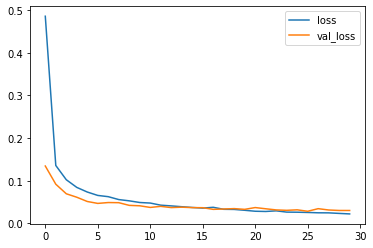

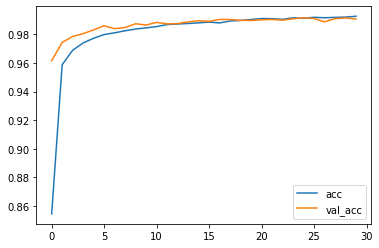

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout

input_shape = (28, 28, 1)

model = Sequential()
model.add(
    Input(shape=input_shape,
          name="Input",
          ))
model.add(
    Conv2D(32,
           kernel_size=(3,3),
           activation="relu",
           ))
model.add(
  MaxPooling2D(pool_size=(2, 2),
               ))
model.add(
    Conv2D(64,
           kernel_size=(3,3),
           activation="relu",
           ))
model.add(
  MaxPooling2D(pool_size=(2, 2),
               ))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=nclasses,
                name="Output",
                activation="softmax",
                ))

model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['acc'],
              )

X_train_enc = np.expand_dims(X_train, -1)
X_test_enc = np.expand_dims(X_test, -1)
fit_and_plot(model, X_train_enc, y_train_enc, X_test_enc, y_test_enc, batch_size=128, fit_verbose=1)

Модель светрочной нейронной сети справилась с задачей еще лучше.
Счет в соревновании на Kaggle составил 0.98950.